In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing All the important library

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
import contextlib
import warnings

@contextlib.contextmanager
def suppress_cuda_warnings():
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yield

In [36]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Update this path to the name of your uploaded dataset
dataset_path = "/kaggle/input/food-images-yelp-data"




## Load Data 

FYI.... For the DCGAN Model i took the food class images for the test so for that i extracted all the food label images from Yelp data and saved the file in Solder name 'food_images_yelp_data'. just to reduce the complexcity and smooth running of the model.

In [37]:
# Load Food Images Dataset
dataset = keras.utils.image_dataset_from_directory(
    dataset_path,  # Path to your uploaded dataset
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
)
dataset = dataset.map(lambda x: x / 255.0)  # Normalize to [0, 1]



Found 108047 files.


### Checking Image

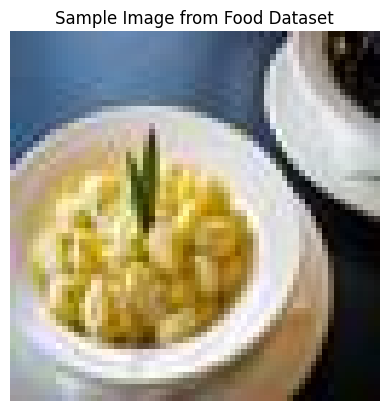

In [38]:
# Display a Sample Image
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy())[2])
    plt.title("Sample Image from Food Dataset")
    plt.show()
    break


The Pictureis not clear becasue i converted the actual image size that is 128 to 64 from yelp data set to my sub data set. just for the testing purpose!

## Discriminator Structure

In [40]:
# Create the Discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()



Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Create the Generator
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()



Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

Override train_step

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([real_images, generated_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

# # Initialize latent dimension
# latent_dim = 100

# # Create Discriminator
# discriminator = keras.Sequential(
#     [
#         keras.Input(shape=(64, 64, 3)),
#         layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(0.2),
#         layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(0.2),
#         layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(0.2),
#         layers.Flatten(),
#         layers.Dropout(0.2),
#         layers.Dense(1, activation="sigmoid"),
#     ]
# )

# # Create Generator
# generator = keras.Sequential(
#     [
#         keras.Input(shape=(latent_dim,)),
#         layers.Dense(8 * 8 * 128),
#         layers.Reshape((8, 8, 128)),
#         layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(0.2),
#         layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(0.2),
#         layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(0.2),
#         layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
#     ]
# )


In [42]:

# GAN Monitor Callback
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")



In [44]:
# Compile and Train the GAN
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

epochs = 2  # Adjust as needed
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


Epoch 1/2
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 497s 146ms/step - d_loss: 0.6868 - g_loss: 0.6966
Epoch 2/2
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 490s 145ms/step - d_loss: 0.6888 - g_loss: 0.6824


In [45]:
# Save the trained GAN model in the default SavedModel format
gan.save("/kaggle/working/gan_final_model.keras")
print("Trained GAN model saved successfully in SavedModel format!")


Trained GAN model saved successfully in SavedModel format!


In [46]:
# Save the trained GAN model in HDF5 format
gan.save("/kaggle/working/gan_final_model.h5")
print("Trained GAN model saved successfully in HDF5 format!")


Trained GAN model saved successfully in HDF5 format!


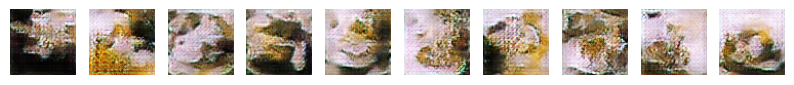

In [21]:
import numpy as np
from tensorflow.keras.utils import array_to_img

# Number of images to generate
num_images = 10

# Generate random latent vectors
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))

# Use the generator to create fake images
generated_images = generator(random_latent_vectors)

# Denormalize the images to bring them back to [0, 255] range
generated_images = (generated_images * 255).numpy().astype("uint8")

# Visualize the generated images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(array_to_img(generated_images[i]))
    plt.axis("off")
plt.show()
